## Linear Regression for Predicting Google Stock Prices

In [77]:
import pandas as pd
import math, datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import pickle

In [119]:
import quandl
quandl.ApiConfig.api_key="bsZzMiC7v9JnsD46JhM3"
dframe = quandl.get('WIKI/GOOGL')

## Data Exploration

In [243]:
df = pd.DataFrame.copy(dframe)
df.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,,,,,,,,,,,
2017-11-03,1042.75,1050.66,1037.65,1049.99,1370874.0,0.0,1.0,1042.75,1050.66,1037.65,1049.99,1370874.0,0.063810,0.694318
2017-11-06,1049.10,1052.59,1042.00,1042.68,897897.0,0.0,1.0,1049.10,1052.59,1042.00,1042.68,897897.0,0.950435,-0.611953
2017-11-07,1049.65,1053.41,1043.00,1052.39,1254965.0,0.0,1.0,1049.65,1053.41,1043.00,1052.39,1254965.0,0.096922,0.261039
2017-11-09,1048.00,1050.88,1035.85,1047.72,1776722.0,0.0,1.0,1048.00,1050.88,1035.85,1047.72,1776722.0,0.301607,-0.026718
2017-11-10,1043.87,1046.63,1041.22,1044.15,955500.0,0.0,1.0,1043.87,1046.63,1041.22,1044.15,955500.0,0.237514,0.026823


## Data Cleaning

#### Lets make to new columns from the data that we already have. ***HL_PCT*** is high low percentage and ***PCT_CHANGE*** is the open close pecrcentage

In [244]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

In [245]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change','Adj. Volume']]
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2017-11-03,1049.99,0.063810,0.694318,1370874.0
2017-11-06,1042.68,0.950435,-0.611953,897897.0
2017-11-07,1052.39,0.096922,0.261039,1254965.0
2017-11-09,1047.72,0.301607,-0.026718,1776722.0
2017-11-10,1044.15,0.237514,0.026823,955500.0


**Adj. Close** is going to be the forecast column

In [246]:
forecast_col='Adj. Close' 

#### Now we are replacing NaN values with outliers. We could have removed those rows altogether, but that would be an unhealthy choice because any other useful data that the row has would be gone.

In [247]:
df.fillna(-99999, inplace=True)

#### We will be using data that came 10% days ago to predict today's price. 10% is the one-tenth of the length of the whole DataFrame.

In [248]:
forecast_out= int(math.ceil(0.01*len(df)))
print(forecast_out)

34


#### Now we will make the new 'label' column for each row to be the 'Adj. Close' price of 10% days into the future. [ In our case, 334 days into the future]

In [249]:
df['label']=df[forecast_col].shift(-forecast_out)

In [250]:
df.head(10)

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.639972
2004-08-20,54.322689,0.710922,7.227007,22834300.0,69.078238
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,67.839414
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,68.912727
2004-08-25,53.164113,1.886792,1.183658,9188600.0,70.668146
2004-08-26,54.122070,0.037068,2.820391,7094800.0,71.219849
2004-08-27,53.239345,2.326896,-1.803885,6211700.0,72.278116
2004-08-30,51.162935,3.411430,-3.106003,5196700.0,74.810934
2004-08-31,51.343492,1.308977,0.048866,4917800.0,74.199045


## Building the Model

### Creating features and Labels

In [251]:
X = np.array(df.drop(['label'],1)) #features
y = np.array(df['label']) # label

In [252]:
len(X), len(y)

(3332, 3332)

### Preprocessing Data
`sklearn.preprocessing` package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.

*Standardization of datasets* is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: *Gaussian with zero mean and unit variance.*

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

In [253]:
from sklearn import preprocessing

In [254]:
X = preprocessing.scale(X) 
# Standardize a dataset along any axis.
# Center to the mean and component wise scale to unit variance.

In [255]:
df.dropna(inplace=True)

In [256]:
len(X), len(y)

(3332, 3332)

In [257]:
X,y = X[:-forecast_out], y[:-forecast_out] # we only have y value for upto this much X value.
X_lately  = X[-forecast_out:] # stuff that we are going to predict against. 
# And they dont have any y data, so can't trainit.

In [258]:
len(X), len(y)

(3298, 3298)

### Splitting the dataset
While experimenting with any learning algorithm, it is important not to test the prediction of an estimator on the data used to fit the estimator as this would not be evaluating the performance of the estimator on new data. This is why datasets are often split into train and test data.
#### A random permutation, to split the data randomly
```python
np.random.seed(42)
indices = np.random.permutation(len(X))
X_train = X[indices[:-20]]
y_train = y[indices[:-20]]
X_test = X[indices[-20:]]
y_test = y[indices[-20:]]
```
#### But we will use the `train_test_split` function from `sklearn.model_selection`

In [259]:
from sklearn.model_selection import train_test_split

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#### Importing the model

In [261]:
from sklearn.linear_model import LinearRegression

#### Create and Fit a Linear Regression Model

In [262]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train) # fit is synonymous with train

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Save the data

In [263]:
with open ('lr.pickle','wb') as f:
    pickle.dump(clf,f)
    
pickle_in = open('lr.pickle','rb')
clf = pickle.load(pickle_in)

## Predictions

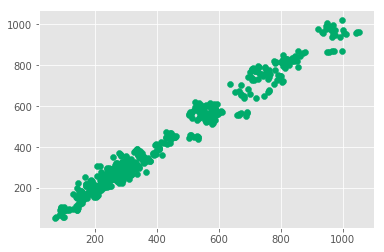

In [264]:
y_pred = clf.predict(X_test)
plt.scatter(y_test,y_pred,color='#00ab6b')

In [265]:
forecast_set = clf.predict(X_lately)
print(forecast_set,forecast_out)

[ 961.48773124  958.98821134  955.46993235  938.02849866  945.04182387
  954.77147583  953.72776715  959.28140001  942.21137775  941.51505128
  936.1041276   955.07909206  957.88666899  952.05010718  945.66901666
  943.50900594  950.26760343  958.85740292  970.30749623  967.6802394
  956.41004517  957.86972011  965.58570111  956.81218632  958.24540048
  962.60735168  965.9168966   955.41697056  950.51771456  945.04973979
  952.54842496  962.34278935  962.92379203  958.37654515] 34


## Evaluation

In [266]:
accuracy= clf.score(X_test,y_test) # score is synonymous with test
print(accuracy)

0.975524932568


### Let's Forecast some data

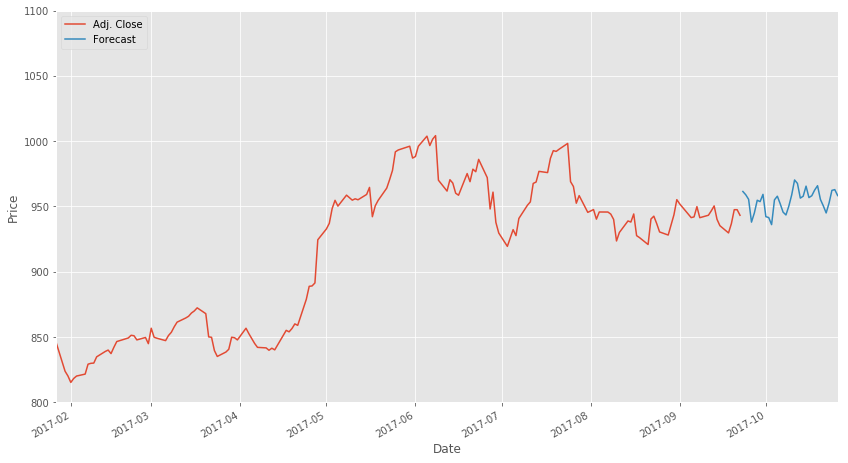

In [267]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name # Timestamp('2017-09-08 00:00:00')
last_unix = last_date.timestamp() # 1504809000.0
one_day = 86400
next_unix = last_unix + one_day # 1504895400.0
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix) # datetime.datetime(2017, 9, 9, 0, 0)
    next_unix+=one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
    
fig,ax=plt.subplots(figsize=(14,8))
ax.set(ylim=[800,1100],xlabel='Date',ylabel='Price')
df=df.tail(200)
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=2)

### Let's use another algorithm

In [268]:
from sklearn import svm

0.61779871785437845

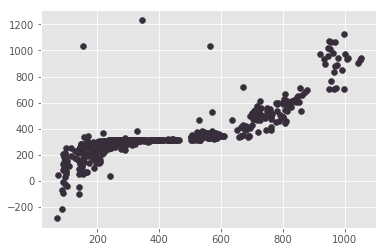

In [269]:
clf2 = svm.SVR( kernel='poly' ) # support vector regression
clf2.fit( X_train, y_train )
y_pred2 = clf2.predict( X_test )
plt.scatter( y_test,y_pred2,color='#372d3b' )
clf2.score( X_test,y_test )